# Project Code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Garbage_Classification_Project'
%ls

/content/drive/MyDrive/Garbage_Classification_Project
 conf_matrix_resnet_fine_tuning.jpg   garbage.jpg
 conf_matrix_resnet.jpg               history_resnet_fine_tuning.jpg
 conf_matrix_vgg_fine_tuning.jpg      history_resnet.jpg
 conf_matrix_vgg.jpg                  history_vgg.jpg
'Garbage classification'/             resnet50.h5
 garbage_classification_CNN.ipynb     vgg19.h5
 garbage_classification.ipynb


In [3]:
!pip install pillow
!pip install termcolor
!pip install tqdm
!pip install joblib
!pip install tensorflow

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from glob import glob
import os

import seaborn as sn # to have a nicer confusion matrix plot

In [5]:
def load_data(df):
  '''Loads data from a dataset where columns are divided in file names and labels respectively'''
  X = []
  y = []
  for index, row in tqdm(df.iterrows()):
      image_file = row['file']
      image_path = glob(IMG_FOLDER + "/**/" + image_file, recursive = True)
      image = plt.imread(image_path[0])
      X.append(image)
      y.append(row['class'])
  return np.array(X), np.array(y)

In [6]:
def vectorize(matrix):
  '''Given a list of images, execute the list vectorization so to have one column representing one image'''
  if len(matrix.shape) == 4:
      n_obj = matrix.shape[0]
      img_width = matrix.shape[1]
      img_height = matrix.shape[2]
      img_channels = matrix.shape[3]

      vector = matrix.flatten().reshape(n_obj, img_width*img_height*img_channels)
      return vector
  return matrix

# Categories
- Glass (0)
- Paper (1)
- CardBoard (2)
- Plastic (3)
- Metal (4)
- Trash (5)

# Read And Anlyze the Data

In [7]:
# Data analysis
DATA_FOLDER = 'Garbage classification'
IMG_FOLDER = os.path.join(DATA_FOLDER, 'Garbage classification')

df = pd.read_csv(os.path.join(DATA_FOLDER, "labeled_images_from_zero.txt"), sep=" ", names=["file","class"])

print(df.info(verbose=True))
print(df.head())
print()

# Load the dataset
print("[INFO] Loading dataset...")
X, y = load_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2527 entries, 0 to 2526
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    2527 non-null   object
 1   class   2527 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.6+ KB
None
         file  class
0  glass1.jpg      0
1  glass2.jpg      0
2  glass3.jpg      0
3  glass4.jpg      0
4  glass5.jpg      0

[INFO] Loading dataset...


2527it [12:24,  3.39it/s]


In [8]:
print(X.shape)
print(y.shape)

(2527, 384, 512, 3)
(2527,)


In [9]:
X_copy = np.copy(X)
y_copy = np.copy(y)

## Plot the Images

In [10]:
# Save the labels to label the confusion matrix when we will do the plot
labels = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

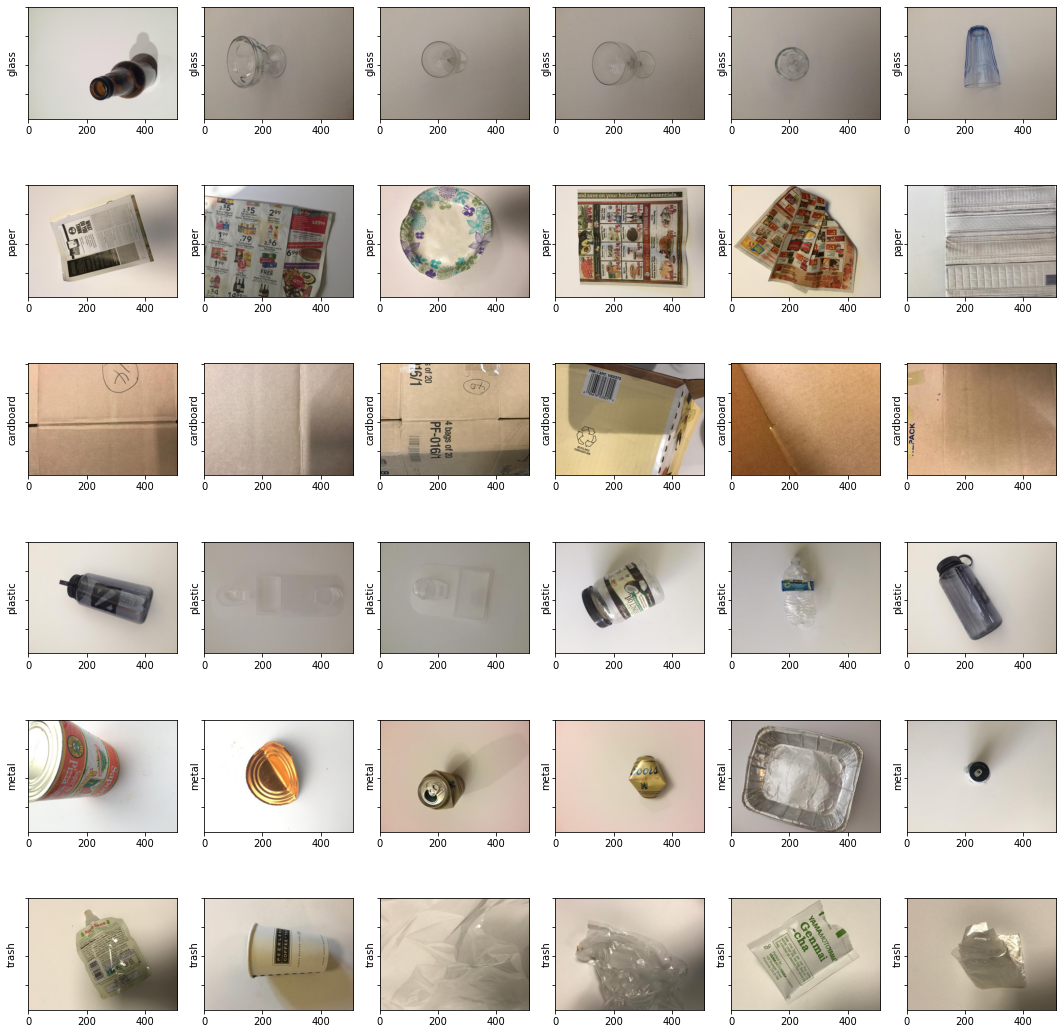

In [11]:
fig, axs = plt.subplots(6, 6, figsize=(15,15), sharey=True)
fig.tight_layout()
for label in range(len(labels)):
  items = X_copy[y_copy == label]
  for i in range(6):
    axs[label, i].imshow(items[i])
    axs[label, i].set_ylabel(labels[label])
    axs[label, i].set_yticklabels([])

plt.savefig('garbage.jpg')
plt.show()


## Resize all the images

In [12]:
from skimage.transform import resize
X_resized = []
for i in tqdm(range(len(X_copy))):
    X_resize = resize(X_copy[i], (X_copy[i].shape[0] // 4, X_copy[i].shape[1] // 4),
                       anti_aliasing=True)
    X_resized.append(X_resize)
X_resized = np.array(X_resized)
print(X_resized.shape)

100%|██████████| 2527/2527 [01:23<00:00, 30.29it/s]


(2527, 96, 128, 3)


## Vectorize the images

In [13]:
X_vector = vectorize(X_resized)
print(X_vector.shape)

(2527, 36864)


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_vector)
X_vector = scaler.transform(X_vector)

## Splitting in test and train set

In [15]:
from sklearn.model_selection import train_test_split

# Provare diversi semi per lo shuffle per vedere risultati 
# X_train, X_test, y_train, y_test = train_test_split(X_vector, y_copy, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_vector, y_copy, test_size=0.25, random_state=20)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1895, 36864)
(632, 36864)
(1895,)
(632,)


# PCA 

In [16]:
from sklearn.decomposition import PCA

In [17]:
import joblib

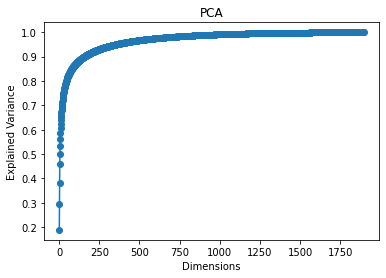

In [18]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
pca_rows = pca.components_.shape[0]
y = np.cumsum(pca.explained_variance_ratio_)/np.sum(pca.explained_variance_ratio_)

# Plot the explained variance ration againts the dimensions, where there is
# an elbow is where we have a good number of preserved variance
plt.title('PCA')
plt.plot(np.arange(1,pca_rows+1), y)
plt.scatter(np.arange(1,pca_rows+1), y)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.show()


In [21]:
model = 'pca.pkl'
if not os.path.isfile(os.path.join(model)):
  pca = PCA(n_components=250)
  pca.fit(X_train)
  # Remember to save the model to avoid the recomputations
  joblib.dump(pca, model)
else:
    pca = joblib.load(os.path.join(model))    
    print("PCA loaded")

In [22]:
# Transfrom the training data, reducing the number of features
X_reduced = pca.transform(X_train)
print(X_reduced.shape)
print("Train set reduced")
# Transform also the test set to
Xt_reduced = pca.transform(X_test)
print("Test set reduced")

(1895, 250)
Train set reduced
Test set reduced


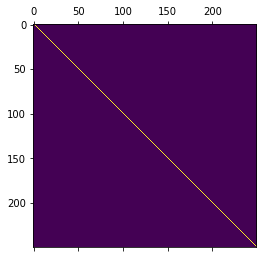

We can see that the features are not correlated


In [23]:
df_plot = pd.DataFrame(X_reduced)
plt.matshow(df_plot.corr())
plt.show()
print("We can see that the features are not correlated")

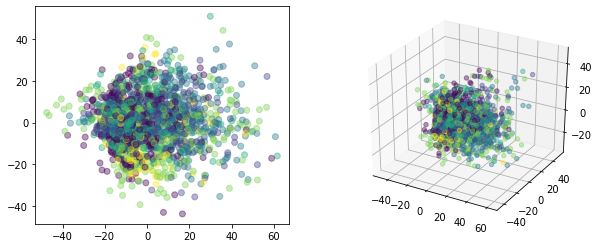

In [24]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train[:], alpha= 0.4);

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter3D(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_train[:], alpha= 0.4);
plt.savefig('data_representation')
plt.show()


In [25]:
from sklearn.model_selection import cross_val_predict
def evaluate_predict_plot(X_train, y_train, X_test, y_test, modelPath, model, targets=labels):
  if os.path.isfile(modelPath):
      model = joblib.load(modelPath)
  else:
      model = model.fit(X_train, y_train)
      joblib.dump(model, modelPath)

  y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)
  conf_train_matrix = confusion_matrix(y_train, y_train_pred)
  
  print("[INFO] Confusion matrix after cross validation for training data\n")
  plt.figure(figsize = (7,7))
  sn.heatmap(conf_train_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
  plt.show()
  print(classification_report(y_train, y_train_pred, target_names=targets))
  print()
  y_pred = model.predict(X_test)
  conf_mat = confusion_matrix(y_test, y_pred)
  print("\n[INFO] Confusion matrix for testing classifications\n")
  plt.figure(figsize = (7,7))
  sn.heatmap(conf_mat, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
  plt.show()
  

  print(classification_report(y_test, y_pred, target_names=targets))
  return model


# Naive Bayes

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [27]:
# training a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

[INFO] Confusion matrix after cross validation for training data



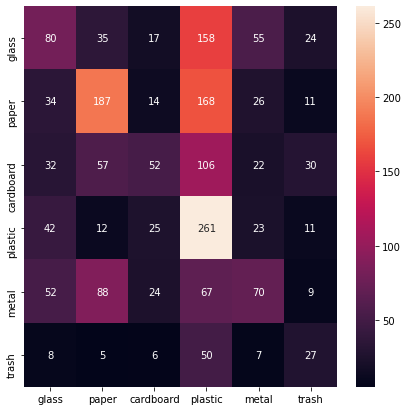

              precision    recall  f1-score   support

       glass       0.32      0.22      0.26       369
       paper       0.49      0.42      0.45       440
   cardboard       0.38      0.17      0.24       299
     plastic       0.32      0.70      0.44       374
       metal       0.34      0.23      0.27       310
       trash       0.24      0.26      0.25       103

    accuracy                           0.36      1895
   macro avg       0.35      0.33      0.32      1895
weighted avg       0.37      0.36      0.34      1895



[INFO] Confusion matrix for testing classifications



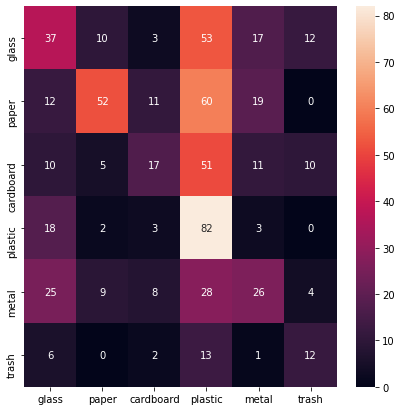

              precision    recall  f1-score   support

       glass       0.34      0.28      0.31       132
       paper       0.67      0.34      0.45       154
   cardboard       0.39      0.16      0.23       104
     plastic       0.29      0.76      0.42       108
       metal       0.34      0.26      0.29       100
       trash       0.32      0.35      0.33        34

    accuracy                           0.36       632
   macro avg       0.39      0.36      0.34       632
weighted avg       0.42      0.36      0.35       632



In [28]:
gnb = GaussianNB()
gnb = evaluate_predict_plot(X_reduced, y_train, Xt_reduced, y_test, 'naive.pkl', gnb)

# K-Nearest Neighbors

In [29]:
from sklearn.neighbors import KNeighborsClassifier

[INFO] Confusion matrix after cross validation for training data



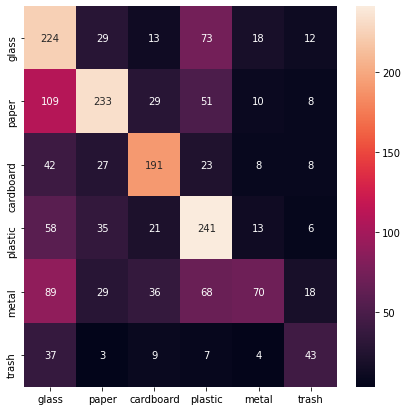

              precision    recall  f1-score   support

       glass       0.40      0.61      0.48       369
       paper       0.65      0.53      0.59       440
   cardboard       0.64      0.64      0.64       299
     plastic       0.52      0.64      0.58       374
       metal       0.57      0.23      0.32       310
       trash       0.45      0.42      0.43       103

    accuracy                           0.53      1895
   macro avg       0.54      0.51      0.51      1895
weighted avg       0.55      0.53      0.52      1895



[INFO] Confusion matrix for testing classifications



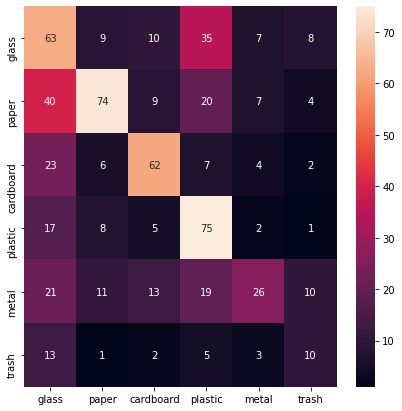

              precision    recall  f1-score   support

       glass       0.36      0.48      0.41       132
       paper       0.68      0.48      0.56       154
   cardboard       0.61      0.60      0.60       104
     plastic       0.47      0.69      0.56       108
       metal       0.53      0.26      0.35       100
       trash       0.29      0.29      0.29        34

    accuracy                           0.49       632
   macro avg       0.49      0.47      0.46       632
weighted avg       0.52      0.49      0.49       632

{'n_neighbors': 3}


In [30]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [2, 3, 5, 10, 100]}
gridKnn = GridSearchCV(knn, param_grid)
gridKnn = evaluate_predict_plot(X_reduced, y_train, Xt_reduced, y_test, 'gridKnn.pkl', gridKnn)
print(gridKnn.best_params_)

# SVM

In [31]:
from sklearn.svm import SVC

[INFO] Confusion matrix after cross validation for training data



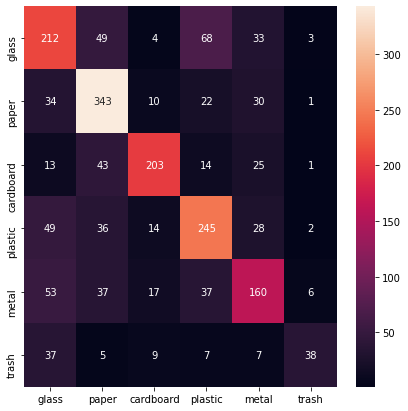

              precision    recall  f1-score   support

       glass       0.53      0.57      0.55       369
       paper       0.67      0.78      0.72       440
   cardboard       0.79      0.68      0.73       299
     plastic       0.62      0.66      0.64       374
       metal       0.57      0.52      0.54       310
       trash       0.75      0.37      0.49       103

    accuracy                           0.63      1895
   macro avg       0.65      0.60      0.61      1895
weighted avg       0.64      0.63      0.63      1895



[INFO] Confusion matrix for testing classifications



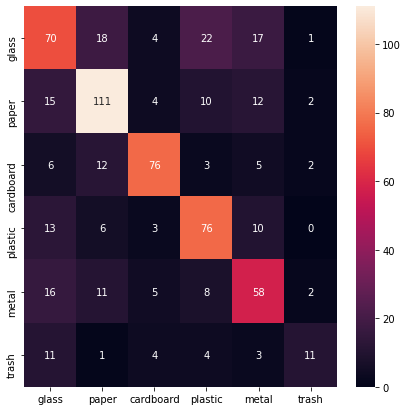

              precision    recall  f1-score   support

       glass       0.53      0.53      0.53       132
       paper       0.70      0.72      0.71       154
   cardboard       0.79      0.73      0.76       104
     plastic       0.62      0.70      0.66       108
       metal       0.55      0.58      0.57       100
       trash       0.61      0.32      0.42        34

    accuracy                           0.64       632
   macro avg       0.63      0.60      0.61       632
weighted avg       0.64      0.64      0.63       632

{'degree': 2, 'kernel': 'rbf'}


In [32]:
svm = SVC()
param_grid_svm = {'kernel' : ['poly', 'linear', 'rbf'], 'degree':[2,3]}
gridSVM = GridSearchCV(svm, param_grid_svm)
gridSVM = evaluate_predict_plot(X_reduced, y_train, Xt_reduced, y_test, "gridSVM.pkl", gridSVM)
print(gridSVM.best_params_)

In [33]:
from sklearn.multiclass import OneVsRestClassifier

[INFO] Confusion matrix after cross validation for training data



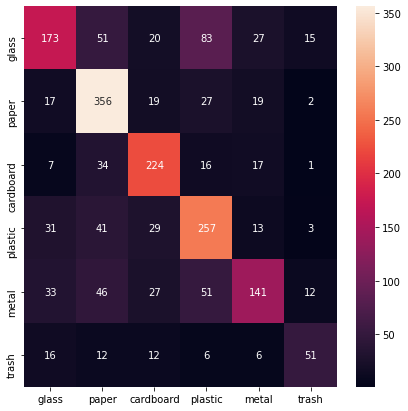

              precision    recall  f1-score   support

       glass       0.62      0.47      0.54       369
       paper       0.66      0.81      0.73       440
   cardboard       0.68      0.75      0.71       299
     plastic       0.58      0.69      0.63       374
       metal       0.63      0.45      0.53       310
       trash       0.61      0.50      0.55       103

    accuracy                           0.63      1895
   macro avg       0.63      0.61      0.61      1895
weighted avg       0.63      0.63      0.63      1895



[INFO] Confusion matrix for testing classifications



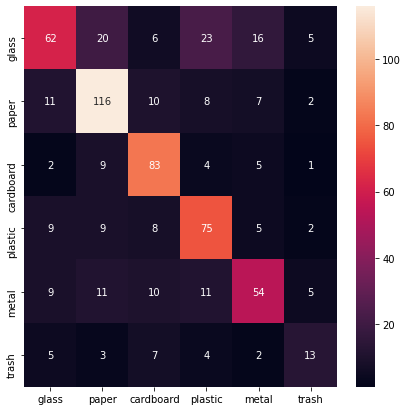

              precision    recall  f1-score   support

       glass       0.63      0.47      0.54       132
       paper       0.69      0.75      0.72       154
   cardboard       0.67      0.80      0.73       104
     plastic       0.60      0.69      0.64       108
       metal       0.61      0.54      0.57       100
       trash       0.46      0.38      0.42        34

    accuracy                           0.64       632
   macro avg       0.61      0.61      0.60       632
weighted avg       0.63      0.64      0.63       632



OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [34]:
ovr_clf = OneVsRestClassifier(SVC())
evaluate_predict_plot(X_reduced, y_train, Xt_reduced, y_test, "svm_ovr.pkl", ovr_clf)